## Outline

We consider a simple model of group of grown up humans. Specifically, we assume a gaussian distribution to be an appropriate probabilistic model for these kind of observations. This gaussian distribution will have unknown mean and standard deviation parameters; in Bayesian inference, these parameters are considered to be random variables, to which a prior probability distribution is assigned.

Then, we assume we have a set of measurements of height of some people, and we want to infer a probability distribution over the parameters. We will perform inference using Approximate Bayesian Computation (ABC), which is a Bayesian inference technique which only requires the ability to simulate from the model.

In the following, we will walk through the steps required to do this in ABCpy. For further information, check also the documentation page where this and other examples are presented as well.

## Probabilistic model

In ABCpy, the probabilistic model is defined hierarchically; here, we first defined put uniform priors on the parameters, which are in turn used to define the model for the height. Each element can be assigned an optional

In [1]:
# define priors
from abcpy.continuousmodels import Uniform, Normal as Gaussian
mu = Uniform([[150], [200]], name="mu")
sigma = Uniform([[5], [25]], name="sigma")
# define the model
height = Gaussian([mu, sigma], name='height')

Each model in ABCpy has to have a `forward_simulate` method, which generates simulations from the model with fixed parameter values:

In [2]:
# generate 3 observations from the model with mean 185 and standard deviation 20
x_sim = height.forward_simulate([185, 20], k=3)
print(x_sim)

[array([181.77649976]), array([218.74431029]), array([180.75721722])]


## Statistics computation

ABC algorithms rely on a measure of discrepancy between the observed dataset and the dataset which is simulated from the model. Often, the discrepancy measure is defined by computing a distance between relevant *summary statistics* extracted from the datasets. Here we first define a way to extract summary statistics from the dataset:

In [3]:
from abcpy.statistics import Identity
statistics_calculator = Identity(degree=2, cross=False)

The above defines an `Identity` statistic, which only applies a polynomial expansion to the data up to the chosen degree (2 here) and optionally adds cross product terms between all the terms in each observation. Let's see how this works:

In [4]:
stat_sim = statistics_calculator.statistics(x_sim)
print(stat_sim.shape)
print(stat_sim[1])

(3, 2)
[  218.74431029 47849.07328477]


The statistic calculator returns a numpy array in which `stat_sim[i]` is the set of statistics corresponding to the $i$-th observation in `x_sim`, which in this case is composed of two elements (the first and second power of the simulated data).

## Discrepany measure

Next we define the discrepancy measure between the datasets, by defining a distance function (we choose here the Euclidean one) between the extracted summary statistics.

In [5]:
from abcpy.distances import Euclidean
distance_calculator = Euclidean(statistics_calculator)

Note that the `Distance` object takes as an argument a `statistics_calculator`; in fact, when calling the corresponding distance method on two dataset, the statistics are computed automatically and the distance between them evaluated:

In [6]:
# generate two observation:
x_1 = height.forward_simulate([185, 20], k=1)
x_2 = height.forward_simulate([170, 20], k=1)

print(distance_calculator.distance(x_1, x_2))

13547.510745555845


## Inference

In order to perform inference, an inference algorithm is required. However, we also need to specify a parallelization backend; here, we use the BackendDummy one, which does not parallelize and is useful for debug and testing; however, ABCpy allows distribution of simulations from the model through MPI and Apache Spark.

In [7]:
from abcpy.backends import BackendDummy as Backend
backend = Backend()

Now, we define the inference algorithm. For simplicity, we use here the basic RejectionABC algorithm. Note that ABCpy implements several more efficient algorithms, which are listed [here](https://abcpy.readthedocs.io/en/latest/getting_started.html#inference-schemes).

To instantiate an inference algorithm, we need to pass to it the model, the distance calculator that will be used during inference and the parallelization backed. We can also pass a seed for random numbers reproducibility:

In [8]:
from abcpy.inferences import RejectionABC
sampler = RejectionABC([height], [distance_calculator], backend, seed=1)

Note that both the model and the distance calculator have to be passed in a list; this may seem superfluous, but the reason is that in ABCpy it is possible to perform inference with models which describe different observations but depend on a common set of parameters; see more details [here](https://abcpy.readthedocs.io/en/latest/getting_started.html#hierarchical-model).

We now generate an observation from which inference is performed:

In [9]:
height_obs = height.forward_simulate([170, 15], k=50)

Finally, we perform sampling by calling the sample method in the sampler. We require to obtain 250 posterior samples (`n_sample` parameter); during the inference procedure, we generate 10 simulations for each parameter value with which to compute the distance from the observation. RejectionABC accepts all parameter values (generated from priors) for which the corresponding distance (between observation and simulated dataset) is smaller than `epsilon`:

In [10]:
# this may take a while according to the setup
n_sample, n_samples_per_param = 250, 10
epsilon = 5000
journal = sampler.sample([height_obs], n_sample, n_samples_per_param, epsilon)

Note that here again the observation is passed in a list; if we were performing inference on multiple models at once, the list would contain an observation for each model.

## Results postprocessing

Now, the inference results are stored in the journal file. We can analyse that in several ways; for instance, we can get the parameter posterior samples:

In [11]:
params = journal.get_parameters()  # this returns a dict whose keys are parameter names
print("Number of posterior samples: {}".format(len(params['mu'])))
print("10 posterior samples for mu:")
print(params['mu'][0:10])

Number of posterior samples: 250
10 posterior samples for mu:
[[array([179.7435489])], [array([172.57267485])], [array([170.7175767])], [array([178.79118242])], [array([175.89380341])], [array([176.17298371])], [array([178.25523055])], [array([170.29002602])], [array([174.08226834])], [array([176.18883946])]]


We can also get the posterior mean and covariance matrix:

In [12]:
print("Posterior mean", journal.posterior_mean())
print("Covariance matrix:")
print(journal.posterior_cov())

Posterior mean {'mu': 171.25216232961665, 'sigma': 9.575057256560035}
Covariance matrix:
(array([[41.54928233, -2.04782502],
       [-2.04782502, 13.81868596]]), dict_keys(['mu', 'sigma']))


The journal also stores the configuration of the sampler with which it was generated:

In [13]:
print(journal.configuration)

{'n_samples': 250, 'n_samples_per_param': 10, 'epsilon': 5000}


Finally, we have a function to plot a kernel density estimate of the obtained posterior; this function has many arguments, allowing to get custom plots:

(<Figure size 576x576 with 4 Axes>,
 array([[<AxesSubplot:title={'center':'mu'}, ylabel='mu'>,
         <AxesSubplot:title={'center':'sigma'}>],
        [<AxesSubplot:xlabel='mu', ylabel='sigma'>,
         <AxesSubplot:xlabel='sigma'>]], dtype=object))

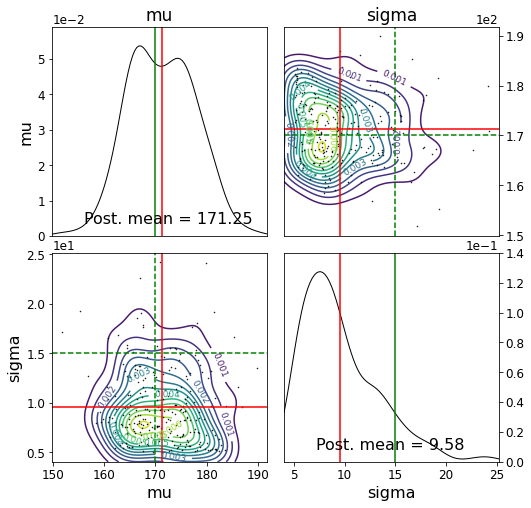

In [14]:
journal.plot_posterior_distr(true_parameter_values=[170,15])

Also, we can save the journal to disk and reload it later:

In [ ]:
from abcpy.output import Journal
journal.save("experiments.jnl")
new_journal = Journal.fromFile('experiments.jnl')

In [35]:
def func1(N):
    a = []
    for i in range(N):
        a.append(i)
    return a 

In [36]:
def func2(N):
    a = [i for i in range(N)]
    return a

In [37]:
import numba

@numba.njit
def func3(N):
    a = []
    for i in range(N):
        a.append(i)
    return a 

In [38]:
import numba

@numba.njit
def func4(N):
    a = [i for i in range(N)]
    return a

In [39]:
N = int(1e6)

In [40]:
%%timeit 

a = func1(N)

66.4 ms ± 2.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
%%timeit 

b = func2(N)

41.5 ms ± 2.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
c = func3(N)
d = func4(N)

In [43]:
%%timeit 

c = func3(N)

27.6 ms ± 543 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [44]:
%%timeit 

d = func4(N)

26.2 ms ± 2.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
